In [1]:
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [2]:
class PINE():
    model_name = "pine_mnist"     # name for checkpoint
    dataset_name = "mnist"

    def __init__(self, batch_size, dataset_name):
    
      # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.y_dim = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 
        self.batch_size = batch_size
        self.learning_rate_main_model = 0.0001
        self.learning_rate_interpreter = 0.0001
        self.checkpoint_dir = 'checkpoint'
        self.dataset_name = dataset_name
 
        # Build and compile the interpreter
        self.interpreter = self.build_interpreter()

        # Build the mian model
        self.main_model = self.build_main_model()

    
#            ___________
#           /           \
#          / MAIN  MODEL \
#         /_______________\        
        
    def build_main_model(self):


        imgs = tf.keras.Input(shape=(28, 28, 1), name="img")
        x = tf.keras.layers.Conv2D(64, 4, activation=LeakyReLU(0.2), strides=2, padding='same')(imgs)
        x = tf.keras.layers.Conv2D(128, 4, activation=LeakyReLU(0.2), strides=2, padding='same')(x)
        x = BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(1024, activation=LeakyReLU(0.2))(x)
        x = BatchNormalization(axis=-1)(x)
        out = tf.keras.layers.Dense(10, activation="softmax")(x)
        model = tf.keras.Model(inputs = imgs, outputs = out)

        print(model.summary())
        return model

    
#          _________________
#          \               /
#           \             /
#            \           /
#             INTERPRETER
#            /           \
#           /             \
#          /_______________\
    
    
    def build_interpreter(self):

        # # Encoder
        encoder_input = tf.keras.Input(shape=(28, 28, 1), name="img")
        x = tf.keras.layers.Conv2D(64, 4, activation="relu",strides=2, padding='same')(encoder_input)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(32)(x)
         # # Decoder
        x = tf.keras.layers.Dense(64 * 14 * 14, activation="relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.Reshape((14, 14, 64))(x)
        out = tf.keras.layers.Conv2DTranspose(1, 4, activation="sigmoid",strides=2, padding='same')(x)


        model = tf.keras.Model(inputs = encoder_input, outputs = out)


        print(model.summary())

        return model
    
    def main_model_loss_fn(self, out_img):
        CatCrossEnt = tf.keras.losses.CategoricalCrossentropy()
        return CatCrossEnt(self.y, out_img)  
    def interpreter_loss_fn(self, ints, out_int, imgs, out_img):
        c1 = 10000
        c2 = 10000
        c3 = 15000
        CatCrossEnt = tf.keras.losses.CategoricalCrossentropy()
        int_error = tf.sqrt(2 * tf.nn.l2_loss(ints - imgs)) / self.batch_size           
        l1 = int_error
        l2 = tf.dtypes.cast(CatCrossEnt(out_img, out_int), tf.float32)
        out_sqrt = tf.keras.backend.sqrt(ints)
        sumi = tf.keras.backend.sum(out_sqrt)**2        
        l3 = sumi  
        return c1*l1+c2*l2+l3/c3

        #################################################### 
        #                                ________________  #
        #    ___________                \               /  #
        #   /           \    Parallel    \             /   #
        #  / MAIN  MODEL \      ||        \           /    #
        # /_______________\  Training      INTERPRETER     #
        #                                 /           \    #
        #                                /             \   #
        #                               /_______________\  #
        ####################################################    
    
    def train(self, epochs, batch_size=128):
        def categorical_accuracy(self, y_true, y_pred):
            return tf.keras.backend.mean(tf.keras.backend.equal(tf.math.argmax(y_true, axis=-1), tf.math.argmax(y_pred, axis=-1)))



        start_batch_id=0
        self.epochs = epochs

        # Load the dataset
        (X_train,y_train), (X_test, y_test) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 255.
        X_train = np.expand_dims(X_train, axis=3)


        X_test = X_test / 255.
        X_test = np.expand_dims(X_test, axis=3)

        y_vec = np.zeros((len(y_train), 10), dtype=np.float)
        for i, label in enumerate(y_train):
            y_vec[i, y_train[i]] = 1.0

        y_vec_test = np.zeros((len(y_test), 10), dtype=np.float)
        for i, label in enumerate(y_test):
            y_vec_test[i, y_test[i]] = 1.0

        
        opt_interpreter = tf.keras.optimizers.Adam(self.learning_rate_interpreter)
        opt_main_model = tf.keras.optimizers.Adam(self.learning_rate_main_model)


        self.num_batches = len(X_train) // self.batch_size  
        for epoch in range(self.epochs):
            for idx in range(start_batch_id, self.num_batches):
                print('Epoch:[',epoch,'] Batch:',idx,'/',self.num_batches, end=" ")
                imgs = X_train[idx * self.batch_size:(idx+1) * self.batch_size]
                self.y = y_vec[idx * self.batch_size:(idx+1) * self.batch_size]

                with tf.GradientTape() as int_tape, tf.GradientTape() as main_tape:

                    ints = self.interpreter(imgs, training=True)
                    
                    out_int = self.main_model(ints, training=True)

                    out_img = self.main_model(imgs, training=True)

                    # Main Model Loss
                    loss_eval = self.main_model_loss_fn(out_img)
                    
                    # Interpreter Loss
                    interpreter_loss = self.interpreter_loss_fn(ints, out_int, imgs, out_img)
                    
                # Get gradients of loss wrt the weights.    
                main_model_grads = main_tape.gradient(loss_eval, self.main_model.trainable_variables)                                           
                interpreter_grads = int_tape.gradient(interpreter_loss, self.interpreter.trainable_variables)

                # Update the weights of the model.
                    
                opt_main_model.apply_gradients(zip(main_model_grads, self.main_model.trainable_variables))                        
                opt_interpreter.apply_gradients(zip(interpreter_grads, self.interpreter.trainable_variables))
                

                

                print('Main Model Loss:',loss_eval.numpy(), end=" ")
                print('Interpreter Loss:',interpreter_loss.numpy())
        

            ints_test = self.interpreter(X_test[0:64], training=False)

            out_int_test = self.main_model(ints_test, training=False)

            out_img_test = self.main_model(X_test[0:64], training=False)

            main_model_acc = categorical_accuracy(self, y_vec_test[0:64],out_img_test)
            interpreter_acc =categorical_accuracy(self, y_vec_test[0:64],out_int_test)
            print(' Main Model Acc: ', main_model_acc.numpy(), 'Interpreter Acc: ', interpreter_acc.numpy())
            self.main_model.save(self.checkpoint_dir)
            self.interpreter.save(self.checkpoint_dir)


In [3]:
if __name__ == '__main__':
    pine = PINE(batch_size=64, dataset_name="mnist")
    pine.train(epochs=5)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                401440    
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             413952    
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)       

Epoch:[ 0 ] Batch: 64 / 937 Main Model Loss: 0.25830138 Interpreter Loss: 103829.164
Epoch:[ 0 ] Batch: 65 / 937 Main Model Loss: 0.3505766 Interpreter Loss: 103837.16
Epoch:[ 0 ] Batch: 66 / 937 Main Model Loss: 0.5353695 Interpreter Loss: 103167.66
Epoch:[ 0 ] Batch: 67 / 937 Main Model Loss: 0.36966184 Interpreter Loss: 102577.016
Epoch:[ 0 ] Batch: 68 / 937 Main Model Loss: 0.26108032 Interpreter Loss: 103051.5
Epoch:[ 0 ] Batch: 69 / 937 Main Model Loss: 0.16889888 Interpreter Loss: 104021.57
Epoch:[ 0 ] Batch: 70 / 937 Main Model Loss: 0.14491834 Interpreter Loss: 102313.31
Epoch:[ 0 ] Batch: 71 / 937 Main Model Loss: 0.10331985 Interpreter Loss: 102768.555
Epoch:[ 0 ] Batch: 72 / 937 Main Model Loss: 0.34886116 Interpreter Loss: 104375.91
Epoch:[ 0 ] Batch: 73 / 937 Main Model Loss: 0.17731528 Interpreter Loss: 103576.125
Epoch:[ 0 ] Batch: 74 / 937 Main Model Loss: 0.3332975 Interpreter Loss: 102911.29
Epoch:[ 0 ] Batch: 75 / 937 Main Model Loss: 0.19273831 Interpreter Loss: 10

Epoch:[ 0 ] Batch: 162 / 937 Main Model Loss: 0.14466569 Interpreter Loss: 100512.87
Epoch:[ 0 ] Batch: 163 / 937 Main Model Loss: 0.083505824 Interpreter Loss: 101540.586
Epoch:[ 0 ] Batch: 164 / 937 Main Model Loss: 0.08120722 Interpreter Loss: 100678.39
Epoch:[ 0 ] Batch: 165 / 937 Main Model Loss: 0.11442496 Interpreter Loss: 101376.36
Epoch:[ 0 ] Batch: 166 / 937 Main Model Loss: 0.12756118 Interpreter Loss: 100672.78
Epoch:[ 0 ] Batch: 167 / 937 Main Model Loss: 0.18595552 Interpreter Loss: 101276.69
Epoch:[ 0 ] Batch: 168 / 937 Main Model Loss: 0.24144441 Interpreter Loss: 101484.266
Epoch:[ 0 ] Batch: 169 / 937 Main Model Loss: 0.19018412 Interpreter Loss: 100721.766
Epoch:[ 0 ] Batch: 170 / 937 Main Model Loss: 0.1250321 Interpreter Loss: 100361.85
Epoch:[ 0 ] Batch: 171 / 937 Main Model Loss: 0.1801266 Interpreter Loss: 100978.05
Epoch:[ 0 ] Batch: 172 / 937 Main Model Loss: 0.19019741 Interpreter Loss: 100000.09
Epoch:[ 0 ] Batch: 173 / 937 Main Model Loss: 0.17622793 Interp

Epoch:[ 0 ] Batch: 260 / 937 Main Model Loss: 0.2476624 Interpreter Loss: 98562.95
Epoch:[ 0 ] Batch: 261 / 937 Main Model Loss: 0.30956545 Interpreter Loss: 97261.44
Epoch:[ 0 ] Batch: 262 / 937 Main Model Loss: 0.11463369 Interpreter Loss: 99054.22
Epoch:[ 0 ] Batch: 263 / 937 Main Model Loss: 0.1862245 Interpreter Loss: 98019.06
Epoch:[ 0 ] Batch: 264 / 937 Main Model Loss: 0.09487066 Interpreter Loss: 98001.75
Epoch:[ 0 ] Batch: 265 / 937 Main Model Loss: 0.17920311 Interpreter Loss: 98714.41
Epoch:[ 0 ] Batch: 266 / 937 Main Model Loss: 0.28917137 Interpreter Loss: 98251.6
Epoch:[ 0 ] Batch: 267 / 937 Main Model Loss: 0.16119164 Interpreter Loss: 97953.625
Epoch:[ 0 ] Batch: 268 / 937 Main Model Loss: 0.11945814 Interpreter Loss: 97024.28
Epoch:[ 0 ] Batch: 269 / 937 Main Model Loss: 0.18361913 Interpreter Loss: 96960.54
Epoch:[ 0 ] Batch: 270 / 937 Main Model Loss: 0.09936419 Interpreter Loss: 96932.516
Epoch:[ 0 ] Batch: 271 / 937 Main Model Loss: 0.12616679 Interpreter Loss: 97

Epoch:[ 0 ] Batch: 358 / 937 Main Model Loss: 0.008294015 Interpreter Loss: 89830.17
Epoch:[ 0 ] Batch: 359 / 937 Main Model Loss: 0.04996095 Interpreter Loss: 90482.01
Epoch:[ 0 ] Batch: 360 / 937 Main Model Loss: 0.18043755 Interpreter Loss: 92179.88
Epoch:[ 0 ] Batch: 361 / 937 Main Model Loss: 0.09682104 Interpreter Loss: 90010.69
Epoch:[ 0 ] Batch: 362 / 937 Main Model Loss: 0.09322943 Interpreter Loss: 90193.33
Epoch:[ 0 ] Batch: 363 / 937 Main Model Loss: 0.03539306 Interpreter Loss: 89882.59
Epoch:[ 0 ] Batch: 364 / 937 Main Model Loss: 0.039001837 Interpreter Loss: 89654.57
Epoch:[ 0 ] Batch: 365 / 937 Main Model Loss: 0.14632796 Interpreter Loss: 90004.86
Epoch:[ 0 ] Batch: 366 / 937 Main Model Loss: 0.102785595 Interpreter Loss: 90987.37
Epoch:[ 0 ] Batch: 367 / 937 Main Model Loss: 0.110848285 Interpreter Loss: 90178.94
Epoch:[ 0 ] Batch: 368 / 937 Main Model Loss: 0.10865834 Interpreter Loss: 89428.49
Epoch:[ 0 ] Batch: 369 / 937 Main Model Loss: 0.18531498 Interpreter Los

Epoch:[ 0 ] Batch: 456 / 937 Main Model Loss: 0.16091101 Interpreter Loss: 80980.01
Epoch:[ 0 ] Batch: 457 / 937 Main Model Loss: 0.14287895 Interpreter Loss: 80861.16
Epoch:[ 0 ] Batch: 458 / 937 Main Model Loss: 0.10983405 Interpreter Loss: 80883.99
Epoch:[ 0 ] Batch: 459 / 937 Main Model Loss: 0.12009959 Interpreter Loss: 79335.125
Epoch:[ 0 ] Batch: 460 / 937 Main Model Loss: 0.1304654 Interpreter Loss: 79766.81
Epoch:[ 0 ] Batch: 461 / 937 Main Model Loss: 0.027146185 Interpreter Loss: 78336.37
Epoch:[ 0 ] Batch: 462 / 937 Main Model Loss: 0.039618775 Interpreter Loss: 79310.22
Epoch:[ 0 ] Batch: 463 / 937 Main Model Loss: 0.06577433 Interpreter Loss: 78633.81
Epoch:[ 0 ] Batch: 464 / 937 Main Model Loss: 0.17158504 Interpreter Loss: 80189.05
Epoch:[ 0 ] Batch: 465 / 937 Main Model Loss: 0.043651924 Interpreter Loss: 78943.92
Epoch:[ 0 ] Batch: 466 / 937 Main Model Loss: 0.1617911 Interpreter Loss: 80502.805
Epoch:[ 0 ] Batch: 467 / 937 Main Model Loss: 0.11259237 Interpreter Loss

Epoch:[ 0 ] Batch: 554 / 937 Main Model Loss: 0.24573621 Interpreter Loss: 65565.95
Epoch:[ 0 ] Batch: 555 / 937 Main Model Loss: 0.059526198 Interpreter Loss: 64997.63
Epoch:[ 0 ] Batch: 556 / 937 Main Model Loss: 0.099933326 Interpreter Loss: 65326.14
Epoch:[ 0 ] Batch: 557 / 937 Main Model Loss: 0.123946145 Interpreter Loss: 65317.805
Epoch:[ 0 ] Batch: 558 / 937 Main Model Loss: 0.030028284 Interpreter Loss: 64927.74
Epoch:[ 0 ] Batch: 559 / 937 Main Model Loss: 0.022581505 Interpreter Loss: 64034.28
Epoch:[ 0 ] Batch: 560 / 937 Main Model Loss: 0.09613941 Interpreter Loss: 64201.21
Epoch:[ 0 ] Batch: 561 / 937 Main Model Loss: 0.124918096 Interpreter Loss: 64777.72
Epoch:[ 0 ] Batch: 562 / 937 Main Model Loss: 0.08217356 Interpreter Loss: 64726.812
Epoch:[ 0 ] Batch: 563 / 937 Main Model Loss: 0.16591948 Interpreter Loss: 64480.15
Epoch:[ 0 ] Batch: 564 / 937 Main Model Loss: 0.13879064 Interpreter Loss: 64133.477
Epoch:[ 0 ] Batch: 565 / 937 Main Model Loss: 0.11912545 Interprete

Epoch:[ 0 ] Batch: 652 / 937 Main Model Loss: 0.11719025 Interpreter Loss: 50363.29
Epoch:[ 0 ] Batch: 653 / 937 Main Model Loss: 0.05817323 Interpreter Loss: 50552.023
Epoch:[ 0 ] Batch: 654 / 937 Main Model Loss: 0.09800264 Interpreter Loss: 52092.58
Epoch:[ 0 ] Batch: 655 / 937 Main Model Loss: 0.04461002 Interpreter Loss: 51630.44
Epoch:[ 0 ] Batch: 656 / 937 Main Model Loss: 0.10782011 Interpreter Loss: 51384.04
Epoch:[ 0 ] Batch: 657 / 937 Main Model Loss: 0.016523391 Interpreter Loss: 50406.7
Epoch:[ 0 ] Batch: 658 / 937 Main Model Loss: 0.03327122 Interpreter Loss: 51601.58
Epoch:[ 0 ] Batch: 659 / 937 Main Model Loss: 0.11803667 Interpreter Loss: 50826.145
Epoch:[ 0 ] Batch: 660 / 937 Main Model Loss: 0.047094796 Interpreter Loss: 50269.06
Epoch:[ 0 ] Batch: 661 / 937 Main Model Loss: 0.16137269 Interpreter Loss: 51157.15
Epoch:[ 0 ] Batch: 662 / 937 Main Model Loss: 0.11207011 Interpreter Loss: 50947.71
Epoch:[ 0 ] Batch: 663 / 937 Main Model Loss: 0.2528882 Interpreter Loss:

Epoch:[ 0 ] Batch: 750 / 937 Main Model Loss: 0.03691721 Interpreter Loss: 40571.145
Epoch:[ 0 ] Batch: 751 / 937 Main Model Loss: 0.19306493 Interpreter Loss: 40909.97
Epoch:[ 0 ] Batch: 752 / 937 Main Model Loss: 0.03214815 Interpreter Loss: 40070.723
Epoch:[ 0 ] Batch: 753 / 937 Main Model Loss: 0.0613786 Interpreter Loss: 40213.363
Epoch:[ 0 ] Batch: 754 / 937 Main Model Loss: 0.06481668 Interpreter Loss: 40010.867
Epoch:[ 0 ] Batch: 755 / 937 Main Model Loss: 0.22052157 Interpreter Loss: 42122.504
Epoch:[ 0 ] Batch: 756 / 937 Main Model Loss: 0.04003316 Interpreter Loss: 40171.695
Epoch:[ 0 ] Batch: 757 / 937 Main Model Loss: 0.078770906 Interpreter Loss: 39887.18
Epoch:[ 0 ] Batch: 758 / 937 Main Model Loss: 0.11605196 Interpreter Loss: 39553.598
Epoch:[ 0 ] Batch: 759 / 937 Main Model Loss: 0.08496696 Interpreter Loss: 39377.57
Epoch:[ 0 ] Batch: 760 / 937 Main Model Loss: 0.12826686 Interpreter Loss: 38948.51
Epoch:[ 0 ] Batch: 761 / 937 Main Model Loss: 0.014292927 Interpreter

Epoch:[ 0 ] Batch: 848 / 937 Main Model Loss: 0.035232373 Interpreter Loss: 31566.762
Epoch:[ 0 ] Batch: 849 / 937 Main Model Loss: 0.019085485 Interpreter Loss: 31761.977
Epoch:[ 0 ] Batch: 850 / 937 Main Model Loss: 0.05209699 Interpreter Loss: 32125.736
Epoch:[ 0 ] Batch: 851 / 937 Main Model Loss: 0.10169078 Interpreter Loss: 31741.871
Epoch:[ 0 ] Batch: 852 / 937 Main Model Loss: 0.111095324 Interpreter Loss: 32478.098
Epoch:[ 0 ] Batch: 853 / 937 Main Model Loss: 0.07282382 Interpreter Loss: 31687.258
Epoch:[ 0 ] Batch: 854 / 937 Main Model Loss: 0.029909946 Interpreter Loss: 31558.453
Epoch:[ 0 ] Batch: 855 / 937 Main Model Loss: 0.087387644 Interpreter Loss: 32559.77
Epoch:[ 0 ] Batch: 856 / 937 Main Model Loss: 0.07233638 Interpreter Loss: 32119.154
Epoch:[ 0 ] Batch: 857 / 937 Main Model Loss: 0.14584416 Interpreter Loss: 32054.455
Epoch:[ 0 ] Batch: 858 / 937 Main Model Loss: 0.09833875 Interpreter Loss: 33347.395
Epoch:[ 0 ] Batch: 859 / 937 Main Model Loss: 0.08038461 Inte

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch:[ 1 ] Batch: 0 / 937 Main Model Loss: 0.057199925 Interpreter Loss: 27209.074
Epoch:[ 1 ] Batch: 1 / 937 Main Model Loss: 0.13030624 Interpreter Loss: 26931.21
Epoch:[ 1 ] Batch: 2 / 937 Main Model Loss: 0.24994227 Interpreter Loss: 26984.498
Epoch:[ 1 ] Batch: 3 / 937 Main Model Loss: 0.04026952 Interpreter Loss: 27231.19
Epoch:[ 1 ] Batch: 4 / 937 Main Model Loss: 0.026041208 Interpreter Loss: 26226.543
Epoch:[ 1 ] Batch: 5 / 937 Main Model Loss: 0.010706741 Interpreter Loss: 25955.89
Epoch:[ 1 ] Batch: 6 / 937 Main Model Loss: 0.09014668 Interpreter Loss: 26717.02
Epoch:[ 1 ] Batch: 7 / 937 Main Model Loss: 0.121875264 Interpreter Loss: 26037.88
Epoch:[ 1 ] Batch: 8 / 937 Main Model Loss: 0.008860335 Interpreter Loss: 26243.848
Epoch:[ 1 ] Batch: 9 / 937 Main Model Loss: 0.104068145 Interpreter Loss: 26806.824
Epoch:[ 1 ] Batch: 10 / 937 Main Model Loss: 0.018338997 Interpreter Loss: 26191.57
Epoch:[ 1 ] Batch: 11 / 937 Main Model Loss: 0.1456781 Interpreter Loss: 27566.11
Epo

Epoch:[ 1 ] Batch: 99 / 937 Main Model Loss: 0.04256729 Interpreter Loss: 23872.918
Epoch:[ 1 ] Batch: 100 / 937 Main Model Loss: 0.120993584 Interpreter Loss: 23570.11
Epoch:[ 1 ] Batch: 101 / 937 Main Model Loss: 0.030081531 Interpreter Loss: 22891.32
Epoch:[ 1 ] Batch: 102 / 937 Main Model Loss: 0.015946122 Interpreter Loss: 22494.172
Epoch:[ 1 ] Batch: 103 / 937 Main Model Loss: 0.023174595 Interpreter Loss: 23679.602
Epoch:[ 1 ] Batch: 104 / 937 Main Model Loss: 0.048995435 Interpreter Loss: 22684.18
Epoch:[ 1 ] Batch: 105 / 937 Main Model Loss: 0.024234755 Interpreter Loss: 22160.205
Epoch:[ 1 ] Batch: 106 / 937 Main Model Loss: 0.119468346 Interpreter Loss: 22466.96
Epoch:[ 1 ] Batch: 107 / 937 Main Model Loss: 0.13163926 Interpreter Loss: 24163.191
Epoch:[ 1 ] Batch: 108 / 937 Main Model Loss: 0.029065717 Interpreter Loss: 24833.912
Epoch:[ 1 ] Batch: 109 / 937 Main Model Loss: 0.13896284 Interpreter Loss: 24457.387
Epoch:[ 1 ] Batch: 110 / 937 Main Model Loss: 0.042241566 Inte

Epoch:[ 1 ] Batch: 195 / 937 Main Model Loss: 0.011604855 Interpreter Loss: 21116.871
Epoch:[ 1 ] Batch: 196 / 937 Main Model Loss: 0.13463861 Interpreter Loss: 22058.617
Epoch:[ 1 ] Batch: 197 / 937 Main Model Loss: 0.102165155 Interpreter Loss: 21936.729
Epoch:[ 1 ] Batch: 198 / 937 Main Model Loss: 0.15181908 Interpreter Loss: 21062.79
Epoch:[ 1 ] Batch: 199 / 937 Main Model Loss: 0.042141873 Interpreter Loss: 20594.066
Epoch:[ 1 ] Batch: 200 / 937 Main Model Loss: 0.045547344 Interpreter Loss: 20495.084
Epoch:[ 1 ] Batch: 201 / 937 Main Model Loss: 0.070393905 Interpreter Loss: 20806.914
Epoch:[ 1 ] Batch: 202 / 937 Main Model Loss: 0.065543845 Interpreter Loss: 22392.656
Epoch:[ 1 ] Batch: 203 / 937 Main Model Loss: 0.10371567 Interpreter Loss: 22131.754
Epoch:[ 1 ] Batch: 204 / 937 Main Model Loss: 0.035735134 Interpreter Loss: 22953.889
Epoch:[ 1 ] Batch: 205 / 937 Main Model Loss: 0.034591272 Interpreter Loss: 21918.45
Epoch:[ 1 ] Batch: 206 / 937 Main Model Loss: 0.020888828 I

Epoch:[ 1 ] Batch: 291 / 937 Main Model Loss: 0.0282553 Interpreter Loss: 18947.904
Epoch:[ 1 ] Batch: 292 / 937 Main Model Loss: 0.041235644 Interpreter Loss: 18932.506
Epoch:[ 1 ] Batch: 293 / 937 Main Model Loss: 0.012303619 Interpreter Loss: 18683.715
Epoch:[ 1 ] Batch: 294 / 937 Main Model Loss: 0.02127012 Interpreter Loss: 19275.293
Epoch:[ 1 ] Batch: 295 / 937 Main Model Loss: 0.007146788 Interpreter Loss: 18425.508
Epoch:[ 1 ] Batch: 296 / 937 Main Model Loss: 0.02372254 Interpreter Loss: 18587.195
Epoch:[ 1 ] Batch: 297 / 937 Main Model Loss: 0.03228046 Interpreter Loss: 17850.111
Epoch:[ 1 ] Batch: 298 / 937 Main Model Loss: 0.1787382 Interpreter Loss: 18307.102
Epoch:[ 1 ] Batch: 299 / 937 Main Model Loss: 0.013895784 Interpreter Loss: 18097.914
Epoch:[ 1 ] Batch: 300 / 937 Main Model Loss: 0.042885166 Interpreter Loss: 20314.152
Epoch:[ 1 ] Batch: 301 / 937 Main Model Loss: 0.022730425 Interpreter Loss: 19102.873
Epoch:[ 1 ] Batch: 302 / 937 Main Model Loss: 0.1467475 Inter

Epoch:[ 1 ] Batch: 387 / 937 Main Model Loss: 0.02082717 Interpreter Loss: 18321.148
Epoch:[ 1 ] Batch: 388 / 937 Main Model Loss: 0.011990545 Interpreter Loss: 17505.145
Epoch:[ 1 ] Batch: 389 / 937 Main Model Loss: 0.11044503 Interpreter Loss: 16939.648
Epoch:[ 1 ] Batch: 390 / 937 Main Model Loss: 0.0048520663 Interpreter Loss: 17508.223
Epoch:[ 1 ] Batch: 391 / 937 Main Model Loss: 0.017134406 Interpreter Loss: 17141.16
Epoch:[ 1 ] Batch: 392 / 937 Main Model Loss: 0.04694394 Interpreter Loss: 17568.25
Epoch:[ 1 ] Batch: 393 / 937 Main Model Loss: 0.12148229 Interpreter Loss: 18006.078
Epoch:[ 1 ] Batch: 394 / 937 Main Model Loss: 0.028185908 Interpreter Loss: 17992.412
Epoch:[ 1 ] Batch: 395 / 937 Main Model Loss: 0.02253407 Interpreter Loss: 19889.492
Epoch:[ 1 ] Batch: 396 / 937 Main Model Loss: 0.003786406 Interpreter Loss: 18571.59
Epoch:[ 1 ] Batch: 397 / 937 Main Model Loss: 0.0024769313 Interpreter Loss: 17951.443
Epoch:[ 1 ] Batch: 398 / 937 Main Model Loss: 0.037821062 In

Epoch:[ 1 ] Batch: 483 / 937 Main Model Loss: 0.024146482 Interpreter Loss: 17094.197
Epoch:[ 1 ] Batch: 484 / 937 Main Model Loss: 0.050756846 Interpreter Loss: 16775.44
Epoch:[ 1 ] Batch: 485 / 937 Main Model Loss: 0.03735323 Interpreter Loss: 16771.348
Epoch:[ 1 ] Batch: 486 / 937 Main Model Loss: 0.018215822 Interpreter Loss: 16389.78
Epoch:[ 1 ] Batch: 487 / 937 Main Model Loss: 0.021602247 Interpreter Loss: 16746.158
Epoch:[ 1 ] Batch: 488 / 937 Main Model Loss: 0.059010975 Interpreter Loss: 17315.217
Epoch:[ 1 ] Batch: 489 / 937 Main Model Loss: 0.055758484 Interpreter Loss: 16974.303
Epoch:[ 1 ] Batch: 490 / 937 Main Model Loss: 0.05125448 Interpreter Loss: 16811.477
Epoch:[ 1 ] Batch: 491 / 937 Main Model Loss: 0.019466586 Interpreter Loss: 16734.639
Epoch:[ 1 ] Batch: 492 / 937 Main Model Loss: 0.07171971 Interpreter Loss: 15685.799
Epoch:[ 1 ] Batch: 493 / 937 Main Model Loss: 0.08098323 Interpreter Loss: 16372.829
Epoch:[ 1 ] Batch: 494 / 937 Main Model Loss: 0.043497276 In

Epoch:[ 1 ] Batch: 579 / 937 Main Model Loss: 0.057579134 Interpreter Loss: 18256.299
Epoch:[ 1 ] Batch: 580 / 937 Main Model Loss: 0.034724552 Interpreter Loss: 17691.469
Epoch:[ 1 ] Batch: 581 / 937 Main Model Loss: 0.020099629 Interpreter Loss: 17511.0
Epoch:[ 1 ] Batch: 582 / 937 Main Model Loss: 0.076728106 Interpreter Loss: 17138.887
Epoch:[ 1 ] Batch: 583 / 937 Main Model Loss: 0.06960161 Interpreter Loss: 17743.201
Epoch:[ 1 ] Batch: 584 / 937 Main Model Loss: 0.08903272 Interpreter Loss: 17069.879
Epoch:[ 1 ] Batch: 585 / 937 Main Model Loss: 0.10895559 Interpreter Loss: 16994.072
Epoch:[ 1 ] Batch: 586 / 937 Main Model Loss: 0.016599337 Interpreter Loss: 15888.879
Epoch:[ 1 ] Batch: 587 / 937 Main Model Loss: 0.005998687 Interpreter Loss: 15617.224
Epoch:[ 1 ] Batch: 588 / 937 Main Model Loss: 0.0474335 Interpreter Loss: 15656.268
Epoch:[ 1 ] Batch: 589 / 937 Main Model Loss: 0.057632346 Interpreter Loss: 17343.148
Epoch:[ 1 ] Batch: 590 / 937 Main Model Loss: 0.10723124 Inte

Epoch:[ 1 ] Batch: 675 / 937 Main Model Loss: 0.015238065 Interpreter Loss: 16066.167
Epoch:[ 1 ] Batch: 676 / 937 Main Model Loss: 0.007351374 Interpreter Loss: 15221.935
Epoch:[ 1 ] Batch: 677 / 937 Main Model Loss: 0.01532291 Interpreter Loss: 15607.573
Epoch:[ 1 ] Batch: 678 / 937 Main Model Loss: 0.12479495 Interpreter Loss: 15322.694
Epoch:[ 1 ] Batch: 679 / 937 Main Model Loss: 0.028007485 Interpreter Loss: 15945.554
Epoch:[ 1 ] Batch: 680 / 937 Main Model Loss: 0.030444656 Interpreter Loss: 15990.18
Epoch:[ 1 ] Batch: 681 / 937 Main Model Loss: 0.036874916 Interpreter Loss: 16199.3955
Epoch:[ 1 ] Batch: 682 / 937 Main Model Loss: 0.07791273 Interpreter Loss: 15699.262
Epoch:[ 1 ] Batch: 683 / 937 Main Model Loss: 0.003567786 Interpreter Loss: 15120.365
Epoch:[ 1 ] Batch: 684 / 937 Main Model Loss: 0.010032343 Interpreter Loss: 15357.864
Epoch:[ 1 ] Batch: 685 / 937 Main Model Loss: 0.061356492 Interpreter Loss: 15801.363
Epoch:[ 1 ] Batch: 686 / 937 Main Model Loss: 0.05085735 

Epoch:[ 1 ] Batch: 771 / 937 Main Model Loss: 0.00744666 Interpreter Loss: 14759.51
Epoch:[ 1 ] Batch: 772 / 937 Main Model Loss: 0.065882415 Interpreter Loss: 15212.827
Epoch:[ 1 ] Batch: 773 / 937 Main Model Loss: 0.13590896 Interpreter Loss: 16556.656
Epoch:[ 1 ] Batch: 774 / 937 Main Model Loss: 0.17798054 Interpreter Loss: 16706.66
Epoch:[ 1 ] Batch: 775 / 937 Main Model Loss: 0.017561715 Interpreter Loss: 15738.606
Epoch:[ 1 ] Batch: 776 / 937 Main Model Loss: 0.008743236 Interpreter Loss: 14687.235
Epoch:[ 1 ] Batch: 777 / 937 Main Model Loss: 0.04250226 Interpreter Loss: 16106.192
Epoch:[ 1 ] Batch: 778 / 937 Main Model Loss: 0.027658053 Interpreter Loss: 14888.677
Epoch:[ 1 ] Batch: 779 / 937 Main Model Loss: 0.1069743 Interpreter Loss: 16463.508
Epoch:[ 1 ] Batch: 780 / 937 Main Model Loss: 0.04961756 Interpreter Loss: 14625.024
Epoch:[ 1 ] Batch: 781 / 937 Main Model Loss: 0.0331093 Interpreter Loss: 14751.943
Epoch:[ 1 ] Batch: 782 / 937 Main Model Loss: 0.010210819 Interpr

Epoch:[ 1 ] Batch: 867 / 937 Main Model Loss: 0.050139207 Interpreter Loss: 15718.445
Epoch:[ 1 ] Batch: 868 / 937 Main Model Loss: 0.044425063 Interpreter Loss: 15475.466
Epoch:[ 1 ] Batch: 869 / 937 Main Model Loss: 0.03469241 Interpreter Loss: 16365.013
Epoch:[ 1 ] Batch: 870 / 937 Main Model Loss: 0.068868235 Interpreter Loss: 16042.35
Epoch:[ 1 ] Batch: 871 / 937 Main Model Loss: 0.01521012 Interpreter Loss: 16077.989
Epoch:[ 1 ] Batch: 872 / 937 Main Model Loss: 0.03536977 Interpreter Loss: 15323.647
Epoch:[ 1 ] Batch: 873 / 937 Main Model Loss: 0.015150682 Interpreter Loss: 14855.289
Epoch:[ 1 ] Batch: 874 / 937 Main Model Loss: 0.010942334 Interpreter Loss: 14582.489
Epoch:[ 1 ] Batch: 875 / 937 Main Model Loss: 0.07997902 Interpreter Loss: 14868.639
Epoch:[ 1 ] Batch: 876 / 937 Main Model Loss: 0.023523109 Interpreter Loss: 14845.143
Epoch:[ 1 ] Batch: 877 / 937 Main Model Loss: 0.06517231 Interpreter Loss: 15415.763
Epoch:[ 1 ] Batch: 878 / 937 Main Model Loss: 0.061998196 In

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch:[ 2 ] Batch: 0 / 937 Main Model Loss: 0.035283074 Interpreter Loss: 14685.544
Epoch:[ 2 ] Batch: 1 / 937 Main Model Loss: 0.08336418 Interpreter Loss: 14837.084
Epoch:[ 2 ] Batch: 2 / 937 Main Model Loss: 0.13215755 Interpreter Loss: 14562.756
Epoch:[ 2 ] Batch: 3 / 937 Main Model Loss: 0.02573736 Interpreter Loss: 14914.54
Epoch:[ 2 ] Batch: 4 / 937 Main Model Loss: 0.013807533 Interpreter Loss: 14028.422
Epoch:[ 2 ] Batch: 5 / 937 Main Model Loss: 0.008007969 Interpreter Loss: 14025.156
Epoch:[ 2 ] Batch: 6 / 937 Main Model Loss: 0.0544623 Interpreter Loss: 14889.824
Epoch:[ 2 ] Batch: 7 / 937 Main Model Loss: 0.065157525 Interpreter Loss: 14426.581
Epoch:[ 2 ] Batch: 8 / 937 Main Model Loss: 0.011177156 Interpreter Loss: 14342.378
Epoch:[ 2 ] Batch: 9 / 937 Main Model Loss: 0.040804952 Interpreter Loss: 14101.08
Epoch:[ 2 ] Batch: 10 / 937 Main Model Loss: 0.009006472 Interpreter Loss: 14485.722
Epoch:[ 2 ] Batch: 11 / 937 Main Model Loss: 0.07847708 Interpreter Loss: 15634.21

Epoch:[ 2 ] Batch: 97 / 937 Main Model Loss: 0.03439462 Interpreter Loss: 15314.537
Epoch:[ 2 ] Batch: 98 / 937 Main Model Loss: 0.024905631 Interpreter Loss: 15076.747
Epoch:[ 2 ] Batch: 99 / 937 Main Model Loss: 0.049578577 Interpreter Loss: 14848.293
Epoch:[ 2 ] Batch: 100 / 937 Main Model Loss: 0.048435494 Interpreter Loss: 15229.096
Epoch:[ 2 ] Batch: 101 / 937 Main Model Loss: 0.023126876 Interpreter Loss: 14301.453
Epoch:[ 2 ] Batch: 102 / 937 Main Model Loss: 0.0023416928 Interpreter Loss: 13327.178
Epoch:[ 2 ] Batch: 103 / 937 Main Model Loss: 0.018073106 Interpreter Loss: 14508.811
Epoch:[ 2 ] Batch: 104 / 937 Main Model Loss: 0.035326738 Interpreter Loss: 13411.916
Epoch:[ 2 ] Batch: 105 / 937 Main Model Loss: 0.005595193 Interpreter Loss: 13016.5625
Epoch:[ 2 ] Batch: 106 / 937 Main Model Loss: 0.0761162 Interpreter Loss: 13433.154
Epoch:[ 2 ] Batch: 107 / 937 Main Model Loss: 0.06625022 Interpreter Loss: 15248.572
Epoch:[ 2 ] Batch: 108 / 937 Main Model Loss: 0.010767123 I

Epoch:[ 2 ] Batch: 193 / 937 Main Model Loss: 0.023308773 Interpreter Loss: 15042.053
Epoch:[ 2 ] Batch: 194 / 937 Main Model Loss: 0.018238619 Interpreter Loss: 14754.71
Epoch:[ 2 ] Batch: 195 / 937 Main Model Loss: 0.008882061 Interpreter Loss: 14352.029
Epoch:[ 2 ] Batch: 196 / 937 Main Model Loss: 0.037664432 Interpreter Loss: 15269.131
Epoch:[ 2 ] Batch: 197 / 937 Main Model Loss: 0.030596405 Interpreter Loss: 15409.104
Epoch:[ 2 ] Batch: 198 / 937 Main Model Loss: 0.018897094 Interpreter Loss: 14629.345
Epoch:[ 2 ] Batch: 199 / 937 Main Model Loss: 0.038326923 Interpreter Loss: 13522.258
Epoch:[ 2 ] Batch: 200 / 937 Main Model Loss: 0.025524184 Interpreter Loss: 13539.554
Epoch:[ 2 ] Batch: 201 / 937 Main Model Loss: 0.022415763 Interpreter Loss: 14140.857
Epoch:[ 2 ] Batch: 202 / 937 Main Model Loss: 0.026258312 Interpreter Loss: 15704.915
Epoch:[ 2 ] Batch: 203 / 937 Main Model Loss: 0.064007215 Interpreter Loss: 15804.697
Epoch:[ 2 ] Batch: 204 / 937 Main Model Loss: 0.0315326

Epoch:[ 2 ] Batch: 290 / 937 Main Model Loss: 0.01530531 Interpreter Loss: 14123.588
Epoch:[ 2 ] Batch: 291 / 937 Main Model Loss: 0.007383938 Interpreter Loss: 13658.202
Epoch:[ 2 ] Batch: 292 / 937 Main Model Loss: 0.027864624 Interpreter Loss: 13944.702
Epoch:[ 2 ] Batch: 293 / 937 Main Model Loss: 0.005890782 Interpreter Loss: 13426.551
Epoch:[ 2 ] Batch: 294 / 937 Main Model Loss: 0.01205854 Interpreter Loss: 13572.166
Epoch:[ 2 ] Batch: 295 / 937 Main Model Loss: 0.0038474933 Interpreter Loss: 13402.0
Epoch:[ 2 ] Batch: 296 / 937 Main Model Loss: 0.0042903186 Interpreter Loss: 13296.292
Epoch:[ 2 ] Batch: 297 / 937 Main Model Loss: 0.0080832 Interpreter Loss: 12852.0
Epoch:[ 2 ] Batch: 298 / 937 Main Model Loss: 0.08916622 Interpreter Loss: 13510.344
Epoch:[ 2 ] Batch: 299 / 937 Main Model Loss: 0.0057903244 Interpreter Loss: 13335.427
Epoch:[ 2 ] Batch: 300 / 937 Main Model Loss: 0.009254651 Interpreter Loss: 15223.068
Epoch:[ 2 ] Batch: 301 / 937 Main Model Loss: 0.014317281 In

Epoch:[ 2 ] Batch: 386 / 937 Main Model Loss: 0.0054170154 Interpreter Loss: 13961.258
Epoch:[ 2 ] Batch: 387 / 937 Main Model Loss: 0.018703127 Interpreter Loss: 14501.33
Epoch:[ 2 ] Batch: 388 / 937 Main Model Loss: 0.012807769 Interpreter Loss: 13533.301
Epoch:[ 2 ] Batch: 389 / 937 Main Model Loss: 0.038412526 Interpreter Loss: 13129.559
Epoch:[ 2 ] Batch: 390 / 937 Main Model Loss: 0.0017179581 Interpreter Loss: 13330.003
Epoch:[ 2 ] Batch: 391 / 937 Main Model Loss: 0.006419729 Interpreter Loss: 13061.957
Epoch:[ 2 ] Batch: 392 / 937 Main Model Loss: 0.020990256 Interpreter Loss: 13525.293
Epoch:[ 2 ] Batch: 393 / 937 Main Model Loss: 0.028180555 Interpreter Loss: 13900.42
Epoch:[ 2 ] Batch: 394 / 937 Main Model Loss: 0.010755559 Interpreter Loss: 13478.719
Epoch:[ 2 ] Batch: 395 / 937 Main Model Loss: 0.0073005445 Interpreter Loss: 15497.252
Epoch:[ 2 ] Batch: 396 / 937 Main Model Loss: 0.002042897 Interpreter Loss: 14588.551
Epoch:[ 2 ] Batch: 397 / 937 Main Model Loss: 0.00365

Epoch:[ 2 ] Batch: 482 / 937 Main Model Loss: 0.025339093 Interpreter Loss: 13737.951
Epoch:[ 2 ] Batch: 483 / 937 Main Model Loss: 0.004856946 Interpreter Loss: 13715.971
Epoch:[ 2 ] Batch: 484 / 937 Main Model Loss: 0.033260614 Interpreter Loss: 13279.988
Epoch:[ 2 ] Batch: 485 / 937 Main Model Loss: 0.019387335 Interpreter Loss: 13645.674
Epoch:[ 2 ] Batch: 486 / 937 Main Model Loss: 0.0059089228 Interpreter Loss: 13043.026
Epoch:[ 2 ] Batch: 487 / 937 Main Model Loss: 0.034346476 Interpreter Loss: 13577.104
Epoch:[ 2 ] Batch: 488 / 937 Main Model Loss: 0.008808356 Interpreter Loss: 13411.34
Epoch:[ 2 ] Batch: 489 / 937 Main Model Loss: 0.013383942 Interpreter Loss: 13588.205
Epoch:[ 2 ] Batch: 490 / 937 Main Model Loss: 0.008859264 Interpreter Loss: 13588.687
Epoch:[ 2 ] Batch: 491 / 937 Main Model Loss: 0.010683321 Interpreter Loss: 13286.468
Epoch:[ 2 ] Batch: 492 / 937 Main Model Loss: 0.05686529 Interpreter Loss: 12420.848
Epoch:[ 2 ] Batch: 493 / 937 Main Model Loss: 0.0810728

Epoch:[ 2 ] Batch: 578 / 937 Main Model Loss: 0.17901604 Interpreter Loss: 13508.407
Epoch:[ 2 ] Batch: 579 / 937 Main Model Loss: 0.042114574 Interpreter Loss: 15431.025
Epoch:[ 2 ] Batch: 580 / 937 Main Model Loss: 0.019293677 Interpreter Loss: 14749.307
Epoch:[ 2 ] Batch: 581 / 937 Main Model Loss: 0.0054589477 Interpreter Loss: 14419.391
Epoch:[ 2 ] Batch: 582 / 937 Main Model Loss: 0.0068162493 Interpreter Loss: 15182.661
Epoch:[ 2 ] Batch: 583 / 937 Main Model Loss: 0.019222422 Interpreter Loss: 15011.866
Epoch:[ 2 ] Batch: 584 / 937 Main Model Loss: 0.036950067 Interpreter Loss: 14436.541
Epoch:[ 2 ] Batch: 585 / 937 Main Model Loss: 0.047716383 Interpreter Loss: 15614.053
Epoch:[ 2 ] Batch: 586 / 937 Main Model Loss: 0.004840022 Interpreter Loss: 13373.658
Epoch:[ 2 ] Batch: 587 / 937 Main Model Loss: 0.006594677 Interpreter Loss: 13013.01
Epoch:[ 2 ] Batch: 588 / 937 Main Model Loss: 0.023616403 Interpreter Loss: 13018.137
Epoch:[ 2 ] Batch: 589 / 937 Main Model Loss: 0.032171

Epoch:[ 2 ] Batch: 674 / 937 Main Model Loss: 0.018448966 Interpreter Loss: 13847.685
Epoch:[ 2 ] Batch: 675 / 937 Main Model Loss: 0.0143618155 Interpreter Loss: 13641.527
Epoch:[ 2 ] Batch: 676 / 937 Main Model Loss: 0.0027535772 Interpreter Loss: 12970.145
Epoch:[ 2 ] Batch: 677 / 937 Main Model Loss: 0.007116332 Interpreter Loss: 13328.981
Epoch:[ 2 ] Batch: 678 / 937 Main Model Loss: 0.09061899 Interpreter Loss: 13045.039
Epoch:[ 2 ] Batch: 679 / 937 Main Model Loss: 0.010250324 Interpreter Loss: 13634.677
Epoch:[ 2 ] Batch: 680 / 937 Main Model Loss: 0.015304892 Interpreter Loss: 13516.312
Epoch:[ 2 ] Batch: 681 / 937 Main Model Loss: 0.0258388 Interpreter Loss: 13907.911
Epoch:[ 2 ] Batch: 682 / 937 Main Model Loss: 0.0366969 Interpreter Loss: 13652.686
Epoch:[ 2 ] Batch: 683 / 937 Main Model Loss: 0.0010128556 Interpreter Loss: 12906.29
Epoch:[ 2 ] Batch: 684 / 937 Main Model Loss: 0.02329561 Interpreter Loss: 13137.891
Epoch:[ 2 ] Batch: 685 / 937 Main Model Loss: 0.016436482 

Epoch:[ 2 ] Batch: 770 / 937 Main Model Loss: 0.010866656 Interpreter Loss: 13076.552
Epoch:[ 2 ] Batch: 771 / 937 Main Model Loss: 0.006277198 Interpreter Loss: 12865.439
Epoch:[ 2 ] Batch: 772 / 937 Main Model Loss: 0.023286838 Interpreter Loss: 13463.374
Epoch:[ 2 ] Batch: 773 / 937 Main Model Loss: 0.035667103 Interpreter Loss: 14170.061
Epoch:[ 2 ] Batch: 774 / 937 Main Model Loss: 0.09577307 Interpreter Loss: 14297.912
Epoch:[ 2 ] Batch: 775 / 937 Main Model Loss: 0.005414056 Interpreter Loss: 13561.68
Epoch:[ 2 ] Batch: 776 / 937 Main Model Loss: 0.005185443 Interpreter Loss: 12441.148
Epoch:[ 2 ] Batch: 777 / 937 Main Model Loss: 0.022034384 Interpreter Loss: 14179.078
Epoch:[ 2 ] Batch: 778 / 937 Main Model Loss: 0.015612993 Interpreter Loss: 12868.359
Epoch:[ 2 ] Batch: 779 / 937 Main Model Loss: 0.034198657 Interpreter Loss: 14426.9795
Epoch:[ 2 ] Batch: 780 / 937 Main Model Loss: 0.013560486 Interpreter Loss: 12945.889
Epoch:[ 2 ] Batch: 781 / 937 Main Model Loss: 0.0089372

Epoch:[ 2 ] Batch: 866 / 937 Main Model Loss: 0.006789717 Interpreter Loss: 12987.183
Epoch:[ 2 ] Batch: 867 / 937 Main Model Loss: 0.010185938 Interpreter Loss: 14078.506
Epoch:[ 2 ] Batch: 868 / 937 Main Model Loss: 0.029338952 Interpreter Loss: 13961.088
Epoch:[ 2 ] Batch: 869 / 937 Main Model Loss: 0.020008512 Interpreter Loss: 14491.456
Epoch:[ 2 ] Batch: 870 / 937 Main Model Loss: 0.06146182 Interpreter Loss: 14447.099
Epoch:[ 2 ] Batch: 871 / 937 Main Model Loss: 0.01094939 Interpreter Loss: 14170.296
Epoch:[ 2 ] Batch: 872 / 937 Main Model Loss: 0.034185216 Interpreter Loss: 13574.683
Epoch:[ 2 ] Batch: 873 / 937 Main Model Loss: 0.012709948 Interpreter Loss: 13515.446
Epoch:[ 2 ] Batch: 874 / 937 Main Model Loss: 0.0026642391 Interpreter Loss: 12923.298
Epoch:[ 2 ] Batch: 875 / 937 Main Model Loss: 0.06096325 Interpreter Loss: 13213.437
Epoch:[ 2 ] Batch: 876 / 937 Main Model Loss: 0.012095382 Interpreter Loss: 13149.531
Epoch:[ 2 ] Batch: 877 / 937 Main Model Loss: 0.02393796

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch:[ 3 ] Batch: 0 / 937 Main Model Loss: 0.008103634 Interpreter Loss: 13173.951
Epoch:[ 3 ] Batch: 1 / 937 Main Model Loss: 0.0143590495 Interpreter Loss: 13868.524
Epoch:[ 3 ] Batch: 2 / 937 Main Model Loss: 0.08984823 Interpreter Loss: 13129.603
Epoch:[ 3 ] Batch: 3 / 937 Main Model Loss: 0.02515901 Interpreter Loss: 13236.854
Epoch:[ 3 ] Batch: 4 / 937 Main Model Loss: 0.008524597 Interpreter Loss: 12492.154
Epoch:[ 3 ] Batch: 5 / 937 Main Model Loss: 0.0072877244 Interpreter Loss: 12671.847
Epoch:[ 3 ] Batch: 6 / 937 Main Model Loss: 0.045522057 Interpreter Loss: 12941.766
Epoch:[ 3 ] Batch: 7 / 937 Main Model Loss: 0.07460966 Interpreter Loss: 13066.152
Epoch:[ 3 ] Batch: 8 / 937 Main Model Loss: 0.004365629 Interpreter Loss: 12689.819
Epoch:[ 3 ] Batch: 9 / 937 Main Model Loss: 0.011697171 Interpreter Loss: 13347.322
Epoch:[ 3 ] Batch: 10 / 937 Main Model Loss: 0.0031603163 Interpreter Loss: 12884.592
Epoch:[ 3 ] Batch: 11 / 937 Main Model Loss: 0.030782538 Interpreter Loss: 

Epoch:[ 3 ] Batch: 97 / 937 Main Model Loss: 0.018396191 Interpreter Loss: 14008.087
Epoch:[ 3 ] Batch: 98 / 937 Main Model Loss: 0.004490343 Interpreter Loss: 13491.059
Epoch:[ 3 ] Batch: 99 / 937 Main Model Loss: 0.017972136 Interpreter Loss: 13582.989
Epoch:[ 3 ] Batch: 100 / 937 Main Model Loss: 0.016734816 Interpreter Loss: 13944.025
Epoch:[ 3 ] Batch: 101 / 937 Main Model Loss: 0.00751598 Interpreter Loss: 13336.704
Epoch:[ 3 ] Batch: 102 / 937 Main Model Loss: 0.0037762315 Interpreter Loss: 12211.5625
Epoch:[ 3 ] Batch: 103 / 937 Main Model Loss: 0.00575864 Interpreter Loss: 13100.193
Epoch:[ 3 ] Batch: 104 / 937 Main Model Loss: 0.0062949173 Interpreter Loss: 11912.429
Epoch:[ 3 ] Batch: 105 / 937 Main Model Loss: 0.003974898 Interpreter Loss: 11749.568
Epoch:[ 3 ] Batch: 106 / 937 Main Model Loss: 0.029330587 Interpreter Loss: 12249.322
Epoch:[ 3 ] Batch: 107 / 937 Main Model Loss: 0.027188512 Interpreter Loss: 13946.496
Epoch:[ 3 ] Batch: 108 / 937 Main Model Loss: 0.00726167

Epoch:[ 3 ] Batch: 193 / 937 Main Model Loss: 0.007831421 Interpreter Loss: 13549.414
Epoch:[ 3 ] Batch: 194 / 937 Main Model Loss: 0.0045401133 Interpreter Loss: 13513.967
Epoch:[ 3 ] Batch: 195 / 937 Main Model Loss: 0.0074631954 Interpreter Loss: 13182.877
Epoch:[ 3 ] Batch: 196 / 937 Main Model Loss: 0.006016607 Interpreter Loss: 14390.971
Epoch:[ 3 ] Batch: 197 / 937 Main Model Loss: 0.012210447 Interpreter Loss: 13985.806
Epoch:[ 3 ] Batch: 198 / 937 Main Model Loss: 0.010458564 Interpreter Loss: 13648.295
Epoch:[ 3 ] Batch: 199 / 937 Main Model Loss: 0.043631688 Interpreter Loss: 12456.917
Epoch:[ 3 ] Batch: 200 / 937 Main Model Loss: 0.0140676005 Interpreter Loss: 12515.659
Epoch:[ 3 ] Batch: 201 / 937 Main Model Loss: 0.014448089 Interpreter Loss: 13281.303
Epoch:[ 3 ] Batch: 202 / 937 Main Model Loss: 0.006583199 Interpreter Loss: 14754.697
Epoch:[ 3 ] Batch: 203 / 937 Main Model Loss: 0.025427887 Interpreter Loss: 15032.016
Epoch:[ 3 ] Batch: 204 / 937 Main Model Loss: 0.038

Epoch:[ 3 ] Batch: 289 / 937 Main Model Loss: 0.02926269 Interpreter Loss: 12671.578
Epoch:[ 3 ] Batch: 290 / 937 Main Model Loss: 0.007348526 Interpreter Loss: 12736.78
Epoch:[ 3 ] Batch: 291 / 937 Main Model Loss: 0.0023278892 Interpreter Loss: 12676.928
Epoch:[ 3 ] Batch: 292 / 937 Main Model Loss: 0.008596561 Interpreter Loss: 12631.776
Epoch:[ 3 ] Batch: 293 / 937 Main Model Loss: 0.0063386713 Interpreter Loss: 12393.043
Epoch:[ 3 ] Batch: 294 / 937 Main Model Loss: 0.010150037 Interpreter Loss: 12609.424
Epoch:[ 3 ] Batch: 295 / 937 Main Model Loss: 0.0015838202 Interpreter Loss: 12505.311
Epoch:[ 3 ] Batch: 296 / 937 Main Model Loss: 0.0012040483 Interpreter Loss: 12268.031
Epoch:[ 3 ] Batch: 297 / 937 Main Model Loss: 0.005157779 Interpreter Loss: 11887.498
Epoch:[ 3 ] Batch: 298 / 937 Main Model Loss: 0.032800976 Interpreter Loss: 12832.93
Epoch:[ 3 ] Batch: 299 / 937 Main Model Loss: 0.005422877 Interpreter Loss: 12522.603
Epoch:[ 3 ] Batch: 300 / 937 Main Model Loss: 0.00554

Epoch:[ 3 ] Batch: 385 / 937 Main Model Loss: 0.010446586 Interpreter Loss: 13638.3
Epoch:[ 3 ] Batch: 386 / 937 Main Model Loss: 0.0037174656 Interpreter Loss: 12902.909
Epoch:[ 3 ] Batch: 387 / 937 Main Model Loss: 0.003335569 Interpreter Loss: 13265.131
Epoch:[ 3 ] Batch: 388 / 937 Main Model Loss: 0.0025725835 Interpreter Loss: 12420.884
Epoch:[ 3 ] Batch: 389 / 937 Main Model Loss: 0.008114036 Interpreter Loss: 12049.873
Epoch:[ 3 ] Batch: 390 / 937 Main Model Loss: 0.0015355635 Interpreter Loss: 12370.914
Epoch:[ 3 ] Batch: 391 / 937 Main Model Loss: 0.0036052994 Interpreter Loss: 12096.754
Epoch:[ 3 ] Batch: 392 / 937 Main Model Loss: 0.01090263 Interpreter Loss: 12696.893
Epoch:[ 3 ] Batch: 393 / 937 Main Model Loss: 0.012975405 Interpreter Loss: 12787.695
Epoch:[ 3 ] Batch: 394 / 937 Main Model Loss: 0.004851021 Interpreter Loss: 12263.185
Epoch:[ 3 ] Batch: 395 / 937 Main Model Loss: 0.008441324 Interpreter Loss: 14395.228
Epoch:[ 3 ] Batch: 396 / 937 Main Model Loss: 0.00085

Epoch:[ 3 ] Batch: 481 / 937 Main Model Loss: 0.008634975 Interpreter Loss: 13083.654
Epoch:[ 3 ] Batch: 482 / 937 Main Model Loss: 0.008219039 Interpreter Loss: 12706.286
Epoch:[ 3 ] Batch: 483 / 937 Main Model Loss: 0.0023798235 Interpreter Loss: 12300.093
Epoch:[ 3 ] Batch: 484 / 937 Main Model Loss: 0.0068934597 Interpreter Loss: 12402.06
Epoch:[ 3 ] Batch: 485 / 937 Main Model Loss: 0.0072335345 Interpreter Loss: 12577.804
Epoch:[ 3 ] Batch: 486 / 937 Main Model Loss: 0.013490064 Interpreter Loss: 12283.373
Epoch:[ 3 ] Batch: 487 / 937 Main Model Loss: 0.0033933478 Interpreter Loss: 12292.164
Epoch:[ 3 ] Batch: 488 / 937 Main Model Loss: 0.019462839 Interpreter Loss: 12402.787
Epoch:[ 3 ] Batch: 489 / 937 Main Model Loss: 0.0038319458 Interpreter Loss: 12636.67
Epoch:[ 3 ] Batch: 490 / 937 Main Model Loss: 0.015687365 Interpreter Loss: 12870.4
Epoch:[ 3 ] Batch: 491 / 937 Main Model Loss: 0.0027003102 Interpreter Loss: 12467.054
Epoch:[ 3 ] Batch: 492 / 937 Main Model Loss: 0.0030

Epoch:[ 3 ] Batch: 577 / 937 Main Model Loss: 0.012034368 Interpreter Loss: 12783.499
Epoch:[ 3 ] Batch: 578 / 937 Main Model Loss: 0.047193136 Interpreter Loss: 12472.609
Epoch:[ 3 ] Batch: 579 / 937 Main Model Loss: 0.019931147 Interpreter Loss: 14497.785
Epoch:[ 3 ] Batch: 580 / 937 Main Model Loss: 0.006187204 Interpreter Loss: 13732.222
Epoch:[ 3 ] Batch: 581 / 937 Main Model Loss: 0.0015583184 Interpreter Loss: 13538.014
Epoch:[ 3 ] Batch: 582 / 937 Main Model Loss: 0.007248452 Interpreter Loss: 13762.459
Epoch:[ 3 ] Batch: 583 / 937 Main Model Loss: 0.014249237 Interpreter Loss: 14133.545
Epoch:[ 3 ] Batch: 584 / 937 Main Model Loss: 0.011749412 Interpreter Loss: 13443.1045
Epoch:[ 3 ] Batch: 585 / 937 Main Model Loss: 0.031614527 Interpreter Loss: 13875.2705
Epoch:[ 3 ] Batch: 586 / 937 Main Model Loss: 0.0047563845 Interpreter Loss: 12128.108
Epoch:[ 3 ] Batch: 587 / 937 Main Model Loss: 0.00353284 Interpreter Loss: 11929.922
Epoch:[ 3 ] Batch: 588 / 937 Main Model Loss: 0.009

Epoch:[ 3 ] Batch: 673 / 937 Main Model Loss: 0.05729969 Interpreter Loss: 11881.129
Epoch:[ 3 ] Batch: 674 / 937 Main Model Loss: 0.016015923 Interpreter Loss: 13685.666
Epoch:[ 3 ] Batch: 675 / 937 Main Model Loss: 0.0034744071 Interpreter Loss: 12930.033
Epoch:[ 3 ] Batch: 676 / 937 Main Model Loss: 0.004671784 Interpreter Loss: 12351.206
Epoch:[ 3 ] Batch: 677 / 937 Main Model Loss: 0.0037258172 Interpreter Loss: 12769.947
Epoch:[ 3 ] Batch: 678 / 937 Main Model Loss: 0.07840579 Interpreter Loss: 12382.425
Epoch:[ 3 ] Batch: 679 / 937 Main Model Loss: 0.0056914063 Interpreter Loss: 12743.642
Epoch:[ 3 ] Batch: 680 / 937 Main Model Loss: 0.009523991 Interpreter Loss: 12509.1045
Epoch:[ 3 ] Batch: 681 / 937 Main Model Loss: 0.015282301 Interpreter Loss: 12979.648
Epoch:[ 3 ] Batch: 682 / 937 Main Model Loss: 0.01976052 Interpreter Loss: 13073.521
Epoch:[ 3 ] Batch: 683 / 937 Main Model Loss: 0.0005795569 Interpreter Loss: 12306.081
Epoch:[ 3 ] Batch: 684 / 937 Main Model Loss: 0.0032

Epoch:[ 3 ] Batch: 769 / 937 Main Model Loss: 0.010742567 Interpreter Loss: 12812.224
Epoch:[ 3 ] Batch: 770 / 937 Main Model Loss: 0.0034032054 Interpreter Loss: 12308.239
Epoch:[ 3 ] Batch: 771 / 937 Main Model Loss: 0.003240046 Interpreter Loss: 12186.852
Epoch:[ 3 ] Batch: 772 / 937 Main Model Loss: 0.053807218 Interpreter Loss: 12843.145
Epoch:[ 3 ] Batch: 773 / 937 Main Model Loss: 0.013221711 Interpreter Loss: 13435.424
Epoch:[ 3 ] Batch: 774 / 937 Main Model Loss: 0.019256797 Interpreter Loss: 13675.587
Epoch:[ 3 ] Batch: 775 / 937 Main Model Loss: 0.0025957362 Interpreter Loss: 12444.847
Epoch:[ 3 ] Batch: 776 / 937 Main Model Loss: 0.0016632064 Interpreter Loss: 11604.38
Epoch:[ 3 ] Batch: 777 / 937 Main Model Loss: 0.03251184 Interpreter Loss: 13209.92
Epoch:[ 3 ] Batch: 778 / 937 Main Model Loss: 0.0029477607 Interpreter Loss: 12011.96
Epoch:[ 3 ] Batch: 779 / 937 Main Model Loss: 0.026115844 Interpreter Loss: 12784.956
Epoch:[ 3 ] Batch: 780 / 937 Main Model Loss: 0.004577

Epoch:[ 3 ] Batch: 865 / 937 Main Model Loss: 0.009050807 Interpreter Loss: 11986.887
Epoch:[ 3 ] Batch: 866 / 937 Main Model Loss: 0.039891448 Interpreter Loss: 13579.779
Epoch:[ 3 ] Batch: 867 / 937 Main Model Loss: 0.010615792 Interpreter Loss: 13600.496
Epoch:[ 3 ] Batch: 868 / 937 Main Model Loss: 0.023496803 Interpreter Loss: 13190.002
Epoch:[ 3 ] Batch: 869 / 937 Main Model Loss: 0.015665814 Interpreter Loss: 14615.645
Epoch:[ 3 ] Batch: 870 / 937 Main Model Loss: 0.020371418 Interpreter Loss: 14739.23
Epoch:[ 3 ] Batch: 871 / 937 Main Model Loss: 0.0026976194 Interpreter Loss: 13747.876
Epoch:[ 3 ] Batch: 872 / 937 Main Model Loss: 0.006059191 Interpreter Loss: 12818.761
Epoch:[ 3 ] Batch: 873 / 937 Main Model Loss: 0.0026166798 Interpreter Loss: 12775.146
Epoch:[ 3 ] Batch: 874 / 937 Main Model Loss: 0.0025078198 Interpreter Loss: 12284.224
Epoch:[ 3 ] Batch: 875 / 937 Main Model Loss: 0.0042999987 Interpreter Loss: 13157.713
Epoch:[ 3 ] Batch: 876 / 937 Main Model Loss: 0.004

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch:[ 4 ] Batch: 0 / 937 Main Model Loss: 0.019272398 Interpreter Loss: 12202.569
Epoch:[ 4 ] Batch: 1 / 937 Main Model Loss: 0.0051955455 Interpreter Loss: 12585.473
Epoch:[ 4 ] Batch: 2 / 937 Main Model Loss: 0.017589608 Interpreter Loss: 13229.726
Epoch:[ 4 ] Batch: 3 / 937 Main Model Loss: 0.0027417035 Interpreter Loss: 13195.184
Epoch:[ 4 ] Batch: 4 / 937 Main Model Loss: 0.030979576 Interpreter Loss: 12303.983
Epoch:[ 4 ] Batch: 5 / 937 Main Model Loss: 0.010254232 Interpreter Loss: 12153.252
Epoch:[ 4 ] Batch: 6 / 937 Main Model Loss: 0.0064910296 Interpreter Loss: 12396.736
Epoch:[ 4 ] Batch: 7 / 937 Main Model Loss: 0.014037506 Interpreter Loss: 12547.229
Epoch:[ 4 ] Batch: 8 / 937 Main Model Loss: 0.027558234 Interpreter Loss: 12317.566
Epoch:[ 4 ] Batch: 9 / 937 Main Model Loss: 0.0042872997 Interpreter Loss: 12116.159
Epoch:[ 4 ] Batch: 10 / 937 Main Model Loss: 0.0044799303 Interpreter Loss: 12676.434
Epoch:[ 4 ] Batch: 11 / 937 Main Model Loss: 0.025574148 Interpreter L

Epoch:[ 4 ] Batch: 97 / 937 Main Model Loss: 0.034219444 Interpreter Loss: 13466.946
Epoch:[ 4 ] Batch: 98 / 937 Main Model Loss: 0.012814147 Interpreter Loss: 13397.52
Epoch:[ 4 ] Batch: 99 / 937 Main Model Loss: 0.01258279 Interpreter Loss: 13017.053
Epoch:[ 4 ] Batch: 100 / 937 Main Model Loss: 0.008602868 Interpreter Loss: 13499.252
Epoch:[ 4 ] Batch: 101 / 937 Main Model Loss: 0.0023625032 Interpreter Loss: 12509.774
Epoch:[ 4 ] Batch: 102 / 937 Main Model Loss: 0.00081589684 Interpreter Loss: 11394.1455
Epoch:[ 4 ] Batch: 103 / 937 Main Model Loss: 0.0095774075 Interpreter Loss: 12535.59
Epoch:[ 4 ] Batch: 104 / 937 Main Model Loss: 0.0067271097 Interpreter Loss: 11523.227
Epoch:[ 4 ] Batch: 105 / 937 Main Model Loss: 0.0018469507 Interpreter Loss: 11421.592
Epoch:[ 4 ] Batch: 106 / 937 Main Model Loss: 0.011848091 Interpreter Loss: 11521.944
Epoch:[ 4 ] Batch: 107 / 937 Main Model Loss: 0.010131542 Interpreter Loss: 13634.321
Epoch:[ 4 ] Batch: 108 / 937 Main Model Loss: 0.00647

Epoch:[ 4 ] Batch: 193 / 937 Main Model Loss: 0.0016856843 Interpreter Loss: 13273.006
Epoch:[ 4 ] Batch: 194 / 937 Main Model Loss: 0.002690997 Interpreter Loss: 12819.466
Epoch:[ 4 ] Batch: 195 / 937 Main Model Loss: 0.0030271946 Interpreter Loss: 12456.285
Epoch:[ 4 ] Batch: 196 / 937 Main Model Loss: 0.005813434 Interpreter Loss: 12995.918
Epoch:[ 4 ] Batch: 197 / 937 Main Model Loss: 0.0055454085 Interpreter Loss: 13461.983
Epoch:[ 4 ] Batch: 198 / 937 Main Model Loss: 0.002214924 Interpreter Loss: 12524.322
Epoch:[ 4 ] Batch: 199 / 937 Main Model Loss: 0.0024929028 Interpreter Loss: 11607.298
Epoch:[ 4 ] Batch: 200 / 937 Main Model Loss: 0.0028261035 Interpreter Loss: 11557.127
Epoch:[ 4 ] Batch: 201 / 937 Main Model Loss: 0.0140847415 Interpreter Loss: 12910.768
Epoch:[ 4 ] Batch: 202 / 937 Main Model Loss: 0.006344223 Interpreter Loss: 14376.103
Epoch:[ 4 ] Batch: 203 / 937 Main Model Loss: 0.0075075715 Interpreter Loss: 14488.763
Epoch:[ 4 ] Batch: 204 / 937 Main Model Loss: 0

Epoch:[ 4 ] Batch: 289 / 937 Main Model Loss: 0.0022189983 Interpreter Loss: 11997.649
Epoch:[ 4 ] Batch: 290 / 937 Main Model Loss: 0.023714243 Interpreter Loss: 12811.826
Epoch:[ 4 ] Batch: 291 / 937 Main Model Loss: 0.0015223264 Interpreter Loss: 12170.38
Epoch:[ 4 ] Batch: 292 / 937 Main Model Loss: 0.005985649 Interpreter Loss: 12664.663
Epoch:[ 4 ] Batch: 293 / 937 Main Model Loss: 0.0039983615 Interpreter Loss: 11733.743
Epoch:[ 4 ] Batch: 294 / 937 Main Model Loss: 0.0036445544 Interpreter Loss: 11566.174
Epoch:[ 4 ] Batch: 295 / 937 Main Model Loss: 0.004280143 Interpreter Loss: 11915.255
Epoch:[ 4 ] Batch: 296 / 937 Main Model Loss: 0.0046300828 Interpreter Loss: 11663.212
Epoch:[ 4 ] Batch: 297 / 937 Main Model Loss: 0.0011856599 Interpreter Loss: 11143.646
Epoch:[ 4 ] Batch: 298 / 937 Main Model Loss: 0.0190008 Interpreter Loss: 12824.49
Epoch:[ 4 ] Batch: 299 / 937 Main Model Loss: 0.0023680264 Interpreter Loss: 11567.039
Epoch:[ 4 ] Batch: 300 / 937 Main Model Loss: 0.041

Epoch:[ 4 ] Batch: 385 / 937 Main Model Loss: 0.0066706226 Interpreter Loss: 12782.072
Epoch:[ 4 ] Batch: 386 / 937 Main Model Loss: 0.0013887589 Interpreter Loss: 11869.236
Epoch:[ 4 ] Batch: 387 / 937 Main Model Loss: 0.009271158 Interpreter Loss: 13135.203
Epoch:[ 4 ] Batch: 388 / 937 Main Model Loss: 0.002414873 Interpreter Loss: 12455.936
Epoch:[ 4 ] Batch: 389 / 937 Main Model Loss: 0.00570646 Interpreter Loss: 10625.675
Epoch:[ 4 ] Batch: 390 / 937 Main Model Loss: 0.00038926137 Interpreter Loss: 11782.176
Epoch:[ 4 ] Batch: 391 / 937 Main Model Loss: 0.0011878598 Interpreter Loss: 11535.218
Epoch:[ 4 ] Batch: 392 / 937 Main Model Loss: 0.013734043 Interpreter Loss: 12155.57
Epoch:[ 4 ] Batch: 393 / 937 Main Model Loss: 0.0032249845 Interpreter Loss: 11911.412
Epoch:[ 4 ] Batch: 394 / 937 Main Model Loss: 0.0022960533 Interpreter Loss: 11406.88
Epoch:[ 4 ] Batch: 395 / 937 Main Model Loss: 0.0038890974 Interpreter Loss: 14931.423
Epoch:[ 4 ] Batch: 396 / 937 Main Model Loss: 0.0

Epoch:[ 4 ] Batch: 481 / 937 Main Model Loss: 0.011289332 Interpreter Loss: 12261.437
Epoch:[ 4 ] Batch: 482 / 937 Main Model Loss: 0.019875046 Interpreter Loss: 11931.842
Epoch:[ 4 ] Batch: 483 / 937 Main Model Loss: 0.027928766 Interpreter Loss: 11646.977
Epoch:[ 4 ] Batch: 484 / 937 Main Model Loss: 0.004681261 Interpreter Loss: 11754.241
Epoch:[ 4 ] Batch: 485 / 937 Main Model Loss: 0.011705456 Interpreter Loss: 11741.016
Epoch:[ 4 ] Batch: 486 / 937 Main Model Loss: 0.0036643692 Interpreter Loss: 11618.891
Epoch:[ 4 ] Batch: 487 / 937 Main Model Loss: 0.0102129085 Interpreter Loss: 11988.918
Epoch:[ 4 ] Batch: 488 / 937 Main Model Loss: 0.0044585513 Interpreter Loss: 11947.087
Epoch:[ 4 ] Batch: 489 / 937 Main Model Loss: 0.004523275 Interpreter Loss: 12110.451
Epoch:[ 4 ] Batch: 490 / 937 Main Model Loss: 0.053778306 Interpreter Loss: 12524.223
Epoch:[ 4 ] Batch: 491 / 937 Main Model Loss: 0.0038576936 Interpreter Loss: 11481.409
Epoch:[ 4 ] Batch: 492 / 937 Main Model Loss: 0.00

Epoch:[ 4 ] Batch: 577 / 937 Main Model Loss: 0.060151994 Interpreter Loss: 12418.036
Epoch:[ 4 ] Batch: 578 / 937 Main Model Loss: 0.022545224 Interpreter Loss: 12349.553
Epoch:[ 4 ] Batch: 579 / 937 Main Model Loss: 0.015648475 Interpreter Loss: 13454.764
Epoch:[ 4 ] Batch: 580 / 937 Main Model Loss: 0.0040999632 Interpreter Loss: 12871.23
Epoch:[ 4 ] Batch: 581 / 937 Main Model Loss: 0.004755648 Interpreter Loss: 12807.061
Epoch:[ 4 ] Batch: 582 / 937 Main Model Loss: 0.0030421668 Interpreter Loss: 13561.539
Epoch:[ 4 ] Batch: 583 / 937 Main Model Loss: 0.0066334037 Interpreter Loss: 13299.353
Epoch:[ 4 ] Batch: 584 / 937 Main Model Loss: 0.0031045666 Interpreter Loss: 12390.03
Epoch:[ 4 ] Batch: 585 / 937 Main Model Loss: 0.006717303 Interpreter Loss: 13307.299
Epoch:[ 4 ] Batch: 586 / 937 Main Model Loss: 0.015091872 Interpreter Loss: 12005.813
Epoch:[ 4 ] Batch: 587 / 937 Main Model Loss: 0.0036267256 Interpreter Loss: 11439.289
Epoch:[ 4 ] Batch: 588 / 937 Main Model Loss: 0.040

Epoch:[ 4 ] Batch: 673 / 937 Main Model Loss: 0.031471062 Interpreter Loss: 11588.98
Epoch:[ 4 ] Batch: 674 / 937 Main Model Loss: 0.0032925154 Interpreter Loss: 12605.697
Epoch:[ 4 ] Batch: 675 / 937 Main Model Loss: 0.0017154084 Interpreter Loss: 11878.513
Epoch:[ 4 ] Batch: 676 / 937 Main Model Loss: 0.008441825 Interpreter Loss: 11651.615
Epoch:[ 4 ] Batch: 677 / 937 Main Model Loss: 0.032296102 Interpreter Loss: 13458.993
Epoch:[ 4 ] Batch: 678 / 937 Main Model Loss: 0.0051964507 Interpreter Loss: 12631.49
Epoch:[ 4 ] Batch: 679 / 937 Main Model Loss: 0.11007752 Interpreter Loss: 11976.286
Epoch:[ 4 ] Batch: 680 / 937 Main Model Loss: 0.013668112 Interpreter Loss: 11806.854
Epoch:[ 4 ] Batch: 681 / 937 Main Model Loss: 0.0018206718 Interpreter Loss: 11830.341
Epoch:[ 4 ] Batch: 682 / 937 Main Model Loss: 0.031160776 Interpreter Loss: 12466.295
Epoch:[ 4 ] Batch: 683 / 937 Main Model Loss: 0.0003104366 Interpreter Loss: 11270.962
Epoch:[ 4 ] Batch: 684 / 937 Main Model Loss: 0.0055

Epoch:[ 4 ] Batch: 769 / 937 Main Model Loss: 0.038773637 Interpreter Loss: 11961.224
Epoch:[ 4 ] Batch: 770 / 937 Main Model Loss: 0.0012154839 Interpreter Loss: 11421.08
Epoch:[ 4 ] Batch: 771 / 937 Main Model Loss: 0.0024693953 Interpreter Loss: 11214.773
Epoch:[ 4 ] Batch: 772 / 937 Main Model Loss: 0.039016496 Interpreter Loss: 11909.682
Epoch:[ 4 ] Batch: 773 / 937 Main Model Loss: 0.040690534 Interpreter Loss: 13104.219
Epoch:[ 4 ] Batch: 774 / 937 Main Model Loss: 0.0881197 Interpreter Loss: 12775.125
Epoch:[ 4 ] Batch: 775 / 937 Main Model Loss: 0.011095802 Interpreter Loss: 12741.396
Epoch:[ 4 ] Batch: 776 / 937 Main Model Loss: 0.0015462779 Interpreter Loss: 11214.748
Epoch:[ 4 ] Batch: 777 / 937 Main Model Loss: 0.023135662 Interpreter Loss: 13003.007
Epoch:[ 4 ] Batch: 778 / 937 Main Model Loss: 0.010156047 Interpreter Loss: 11369.911
Epoch:[ 4 ] Batch: 779 / 937 Main Model Loss: 0.03633062 Interpreter Loss: 12941.385
Epoch:[ 4 ] Batch: 780 / 937 Main Model Loss: 0.0044576

Epoch:[ 4 ] Batch: 865 / 937 Main Model Loss: 0.0021962577 Interpreter Loss: 11034.253
Epoch:[ 4 ] Batch: 866 / 937 Main Model Loss: 0.009251737 Interpreter Loss: 11390.851
Epoch:[ 4 ] Batch: 867 / 937 Main Model Loss: 0.007644904 Interpreter Loss: 12805.433
Epoch:[ 4 ] Batch: 868 / 937 Main Model Loss: 0.013286174 Interpreter Loss: 13005.036
Epoch:[ 4 ] Batch: 869 / 937 Main Model Loss: 0.005995552 Interpreter Loss: 13396.404
Epoch:[ 4 ] Batch: 870 / 937 Main Model Loss: 0.06033737 Interpreter Loss: 13318.849
Epoch:[ 4 ] Batch: 871 / 937 Main Model Loss: 0.013813734 Interpreter Loss: 13588.984
Epoch:[ 4 ] Batch: 872 / 937 Main Model Loss: 0.0126605695 Interpreter Loss: 11738.593
Epoch:[ 4 ] Batch: 873 / 937 Main Model Loss: 0.0050728563 Interpreter Loss: 12781.459
Epoch:[ 4 ] Batch: 874 / 937 Main Model Loss: 0.00066296064 Interpreter Loss: 11361.58
Epoch:[ 4 ] Batch: 875 / 937 Main Model Loss: 0.051014114 Interpreter Loss: 11772.042
Epoch:[ 4 ] Batch: 876 / 937 Main Model Loss: 0.019

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


In [4]:
import pandas as pd
interpreter_model = tf.keras.models.load_model('checkpoint')
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tests = X_test[0:64]
interpreter_model.compile()
interprets = interpreter_model(tests)
interprets = interprets.numpy()

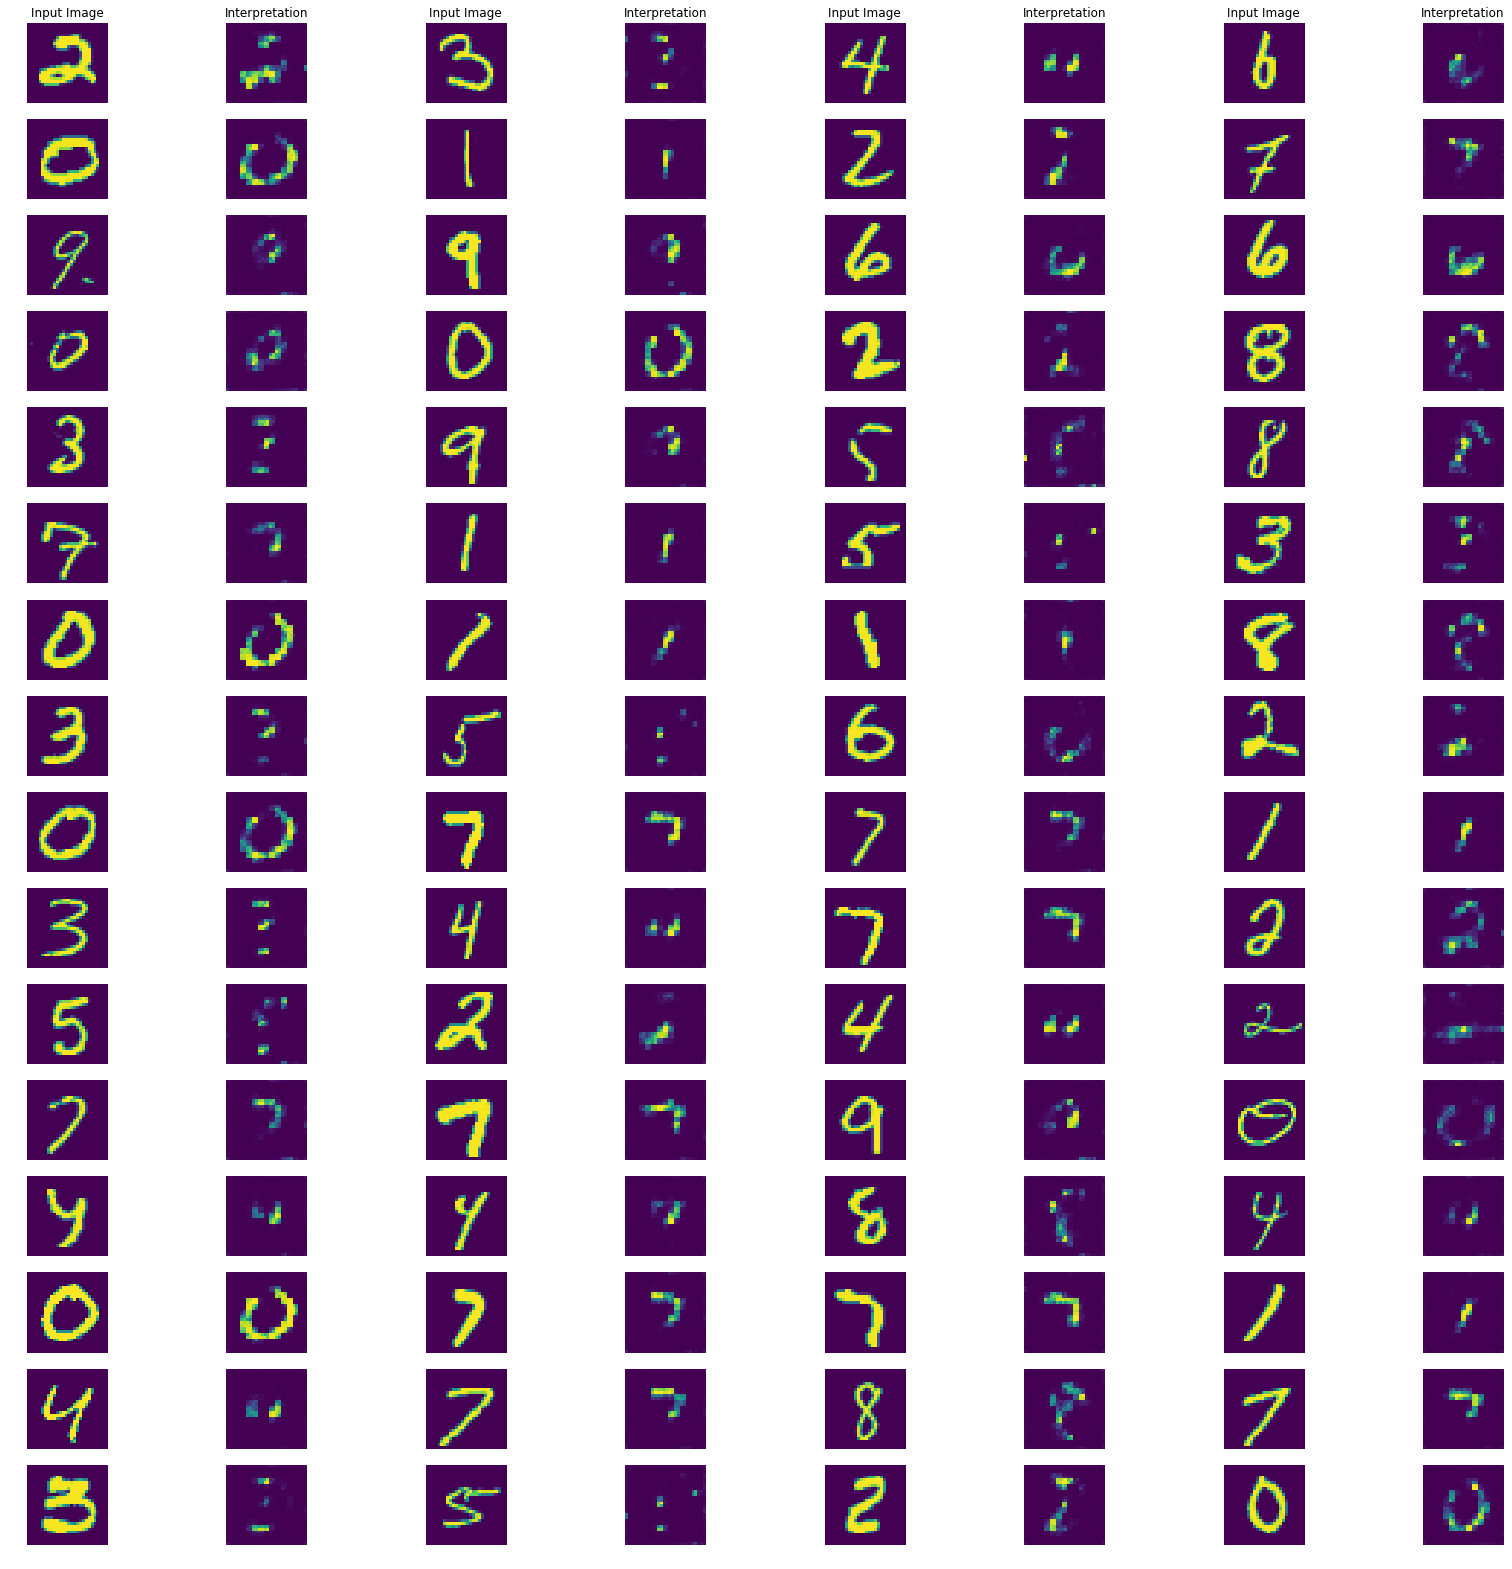

<Figure size 1440x1440 with 0 Axes>

In [5]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        tests_figs = tests[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(tests_figs)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        interprets_figs = interprets[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(interprets_figs)
        axs[i, 2*j+1].axis('off')        
plt.show()